In [1]:
# Parameters
samples_csv = 'results/temp_viralbc_fastqs/illumina_runs_viralbc.csv'
expected_flu_seqs = {
    'fluHA': 'GCGGCCGCCTATGGTGCATCATTATATGCAAAT',
    'fluNA': 'GCGGCCGCCTATGGTGCACTATTATTTATCTAT'
}

In [2]:
import os
import subprocess

import numpy
import gzip

from Bio import SeqIO

import pandas as pd

from plotnine import *
import seaborn as sns

from IPython.display import display, HTML
import mizani

In [3]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

_ = theme_set(theme_classic)

In [4]:
print(f"Reading sample list from from {samples_csv}")
samples_df = pd.read_csv(samples_csv, index_col=False, comment="#")

Reading sample list from from results/temp_viralbc_fastqs/illumina_runs_viralbc.csv


In [5]:
samples_df

,sample,seqrun,source_type,segment,index_name,index_sequence,FASTQ
0,WT_0d15,2020-08-24,cell,fluHA,NextFlex_65,TGGAACAA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
1,WT_0d5,2020-08-25,cell,fluHA,NextFlex_66,TGGCTTCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
2,dblSyn_0d15,2020-08-26,cell,fluHA,NextFlex_67,TGGTGGTA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
3,dblSyn_0d5,2020-08-27,cell,fluHA,NextFlex_68,TTCACGCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
4,WT_0d15,2020-08-28,supernatant,fluHA,NextFlex_70,AAGAGATC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
5,WT_0d5,2020-08-29,supernatant,fluHA,NextFlex_71,AAGGACAC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
6,dblSyn_0d15,2020-08-30,supernatant,fluHA,NextFlex_72,AATCCGTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
7,dblSyn_0d5,2020-08-31,supernatant,fluHA,NextFlex_73,AATGTTGC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
8,WT_0d15,2020-09-01,passage,fluHA,NextFlex_75,ACAGATTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
9,WT_0d5,2020-09-02,passage,fluHA,NextFlex_76,AGATGTAC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...


In [6]:
adapter_seq = 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCACN{8}ATCTCGTATGCCGTCTTCTGCTTG'

trimmed_fastq_files = []

for sample in samples_df.iterrows():
    raw_file = sample[1]["FASTQ"]
    output_file = 'results/temp_viralbc_fastqs/' + 'trimmed_' + sample[1]["FASTQ"].split('/')[-1]
    print(f'Trimming adapters for sample {sample[1]["sample"]} {sample[1]["source_type"]}.')
    cmd = [
        'cutadapt',
        '-O', '13',
        '-a', adapter_seq+'X',
        '-o', output_file,
        raw_file
          ]
    #print(' '.join(cmd))
    if os.path.exists(output_file):
        print('Trimmed file exists.')
    else:
        subprocess.check_call(cmd)
        print('Done.')
    trimmed_fastq_files.append(output_file)

samples_df['trimmed_FASTQ'] = trimmed_fastq_files

Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d15 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d5 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.


In [7]:
#abc = samples_df.query('"WT_0d15" in sample and segment == "fluHA"')

reads_list = []

for sample in samples_df.iterrows():
    fastq_file = sample[1]["trimmed_FASTQ"]
    print(f'Loading reads for sample {sample[1]["sample"]} {sample[1]["segment"]} from {fastq_file}\n')
    with gzip.open(fastq_file, "rt") as fastq_file_open:
        reads = SeqIO.parse(fastq_file_open, format='fastq')
        for record in reads:
            reads_list.append({
                'sample': sample[1]["sample"],
                'source_type': sample[1]["source_type"],
                'segment': sample[1]["segment"],
                'read_name': record.name,
                'sequence': str(record.seq),
                #'phred': record.letter_annotations["phred_quality"],
            })

reads_df = pd.DataFrame(reads_list)
reads_df['source_type'] = pd.Categorical(reads_df['source_type'],
                                        categories=['cell','supernatant','passage'],
                                        ordered=True)
#reads_df

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-015_S1_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-05_S2_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-015_S3_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-05_S4_L001_R1_001.fastq.gz

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-015_S5_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-05_S6_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-dblSyn-015_S7_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-dblSyn-05_S8_L001_R

In [8]:
reads_df['viral_bc'] = reads_df['sequence'].str.slice(0,16)
#reads_df['viral_bc_qual'] = numpy.mean(reads_df['phred'].str.slice(0,16))
reads_df['flu_seq'] = reads_df['sequence'].str.slice(16,49)
reads_df['expected_flu_seq'] = reads_df['segment'].map(expected_flu_seqs)
reads_df['match'] = reads_df['flu_seq'] == reads_df['expected_flu_seq']

In [9]:
reads_df

,sample,source_type,segment,read_name,sequence,viral_bc,flu_seq,expected_flu_seq,match
0,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:21755:2143,CCACGTAACAAATGGTGCGGCCGCCTATGGTGCATCATTATATGCA...,CCACGTAACAAATGGT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
1,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:22590:2161,TACATCGCAAGAATGTGCGGCCGCCTATGGTGCATCATTATATGCA...,TACATCGCAAGAATGT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
2,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:16793:2163,CAACATAAACTGTACGGCGGCCGCCTATGGTGCATCATTATATGCA...,CAACATAAACTGTACG,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
3,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:9442:2179,ACTCCAGGGTAATGACGCGGCCGCCTATGGTGCATCATTATATGCA...,ACTCCAGGGTAATGAC,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
4,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:19569:2181,CTCTTAGATACGCGGAGCGGCCGCCTATGGTGCATCATTATATGCA...,CTCTTAGATACGCGGA,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
...,...,...,...,...,...,...,...,...,...
26541930,Unid_3,cell,fluNA,M04866:401:000000000-J84HR:1:1114:21318:25361,NAATACAAATATAACAGCGGCCGCCTATGGTGCACTNNNNNNTATC...,NAATACAAATATAACA,GCGGCCGCCTATGGTGCACTNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26541931,Unid_3,cell,fluNA,M04866:401:000000000-J84HR:1:1114:16612:25361,NTGTGCCCACTGTCTTGCGGCCGCCTATGGTGCACTNNNNNNTATC...,NTGTGCCCACTGTCTT,GCGGCCGCCTATGGTGCACTNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26541932,Unid_3,cell,fluNA,M04866:401:000000000-J84HR:1:1114:17144:25361,NAGCATCAACAGGCCACAACCAACCAGAACGTGAAANNNNNNCCTG...,NAGCATCAACAGGCCA,CAACCAACCAGAACGTGAAANNNNNNCCTGCGT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26541933,Unid_3,cell,fluNA,M04866:401:000000000-J84HR:1:1114:14740:25362,NCGGTTTTCCTGGTAAGCGGCCGCCTATGGTGCACTNNNNNNTATC...,NCGGTTTTCCTGGTAA,GCGGCCGCCTATGGTGCACTNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False


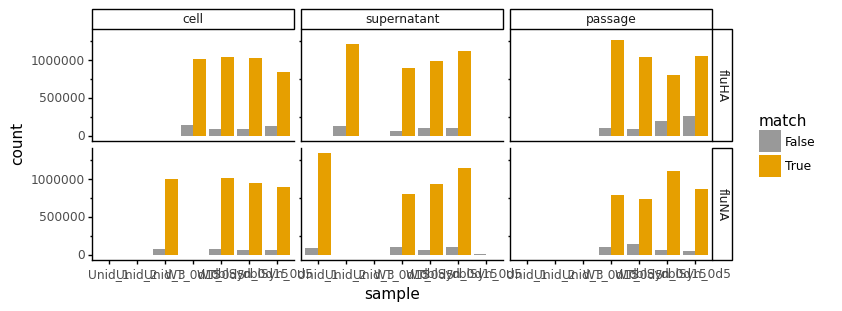

In [10]:
p = (ggplot(reads_df, aes(x='sample', fill='match')) +
     geom_bar(position='dodge') +
     facet_grid('segment~source_type') +
     theme(figure_size=(8, 3)) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [11]:
n_barcodes_df = pd.DataFrame(reads_df.query('match == True').groupby(['sample','source_type','segment'])['viral_bc'].nunique())
n_barcodes_df = n_barcodes_df.reset_index()
n_barcodes_df = n_barcodes_df.rename(columns={'viral_bc':'n_viral_bc'})

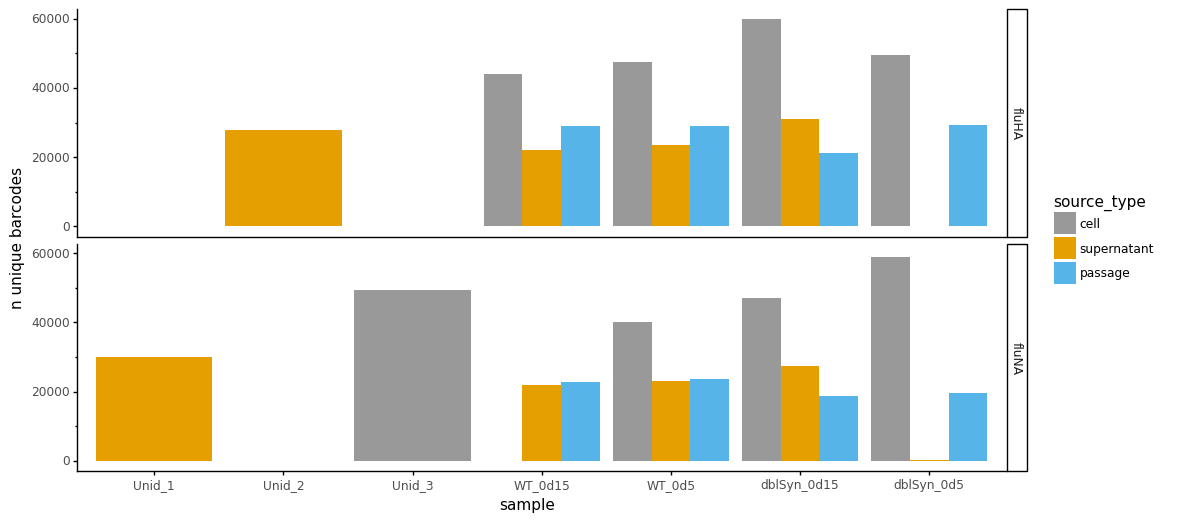

In [12]:
p = (ggplot(n_barcodes_df, aes(x='sample', y='n_viral_bc', fill='source_type')) +
     geom_bar(stat='identity',position='dodge') +
     facet_grid('segment~') +
     theme(figure_size=(12, 6)) +
     ylab('n unique barcodes') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [13]:
barcode_counts_df = pd.DataFrame(reads_df.query('match == True').groupby(['sample','source_type','segment'])['viral_bc'].value_counts())
barcode_counts_df = barcode_counts_df.rename(columns={'viral_bc':'n_reads'})
barcode_counts_df = barcode_counts_df.reset_index(level=['viral_bc','sample','source_type','segment'])

threshold = 0 #cutoff for including a barcode
barcode_counts_df = barcode_counts_df.query(f'n_reads > {threshold}')

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/utils.py:634: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


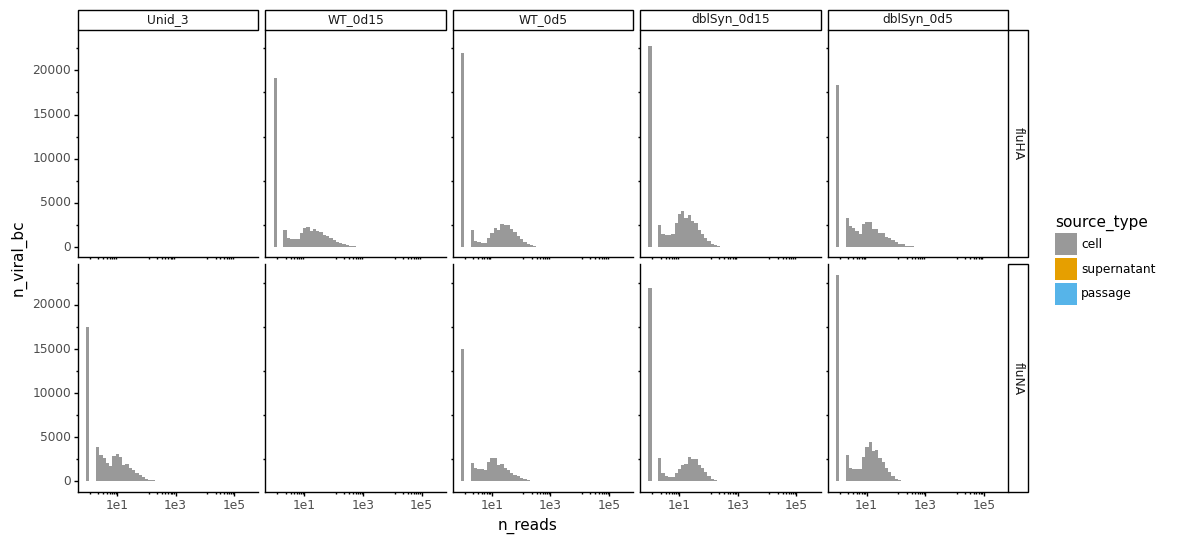

In [15]:
p = (ggplot(barcode_counts_df.query('source_type=="cell"'), aes(x='n_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/utils.py:634: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


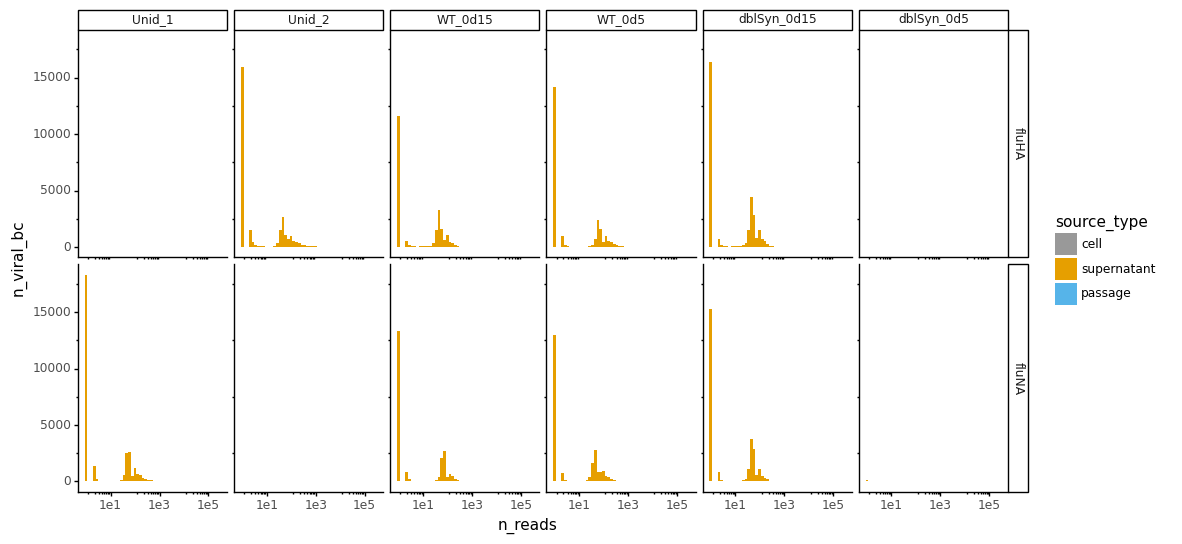

In [17]:
p = (ggplot(barcode_counts_df.query('source_type=="supernatant"'), aes(x='n_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

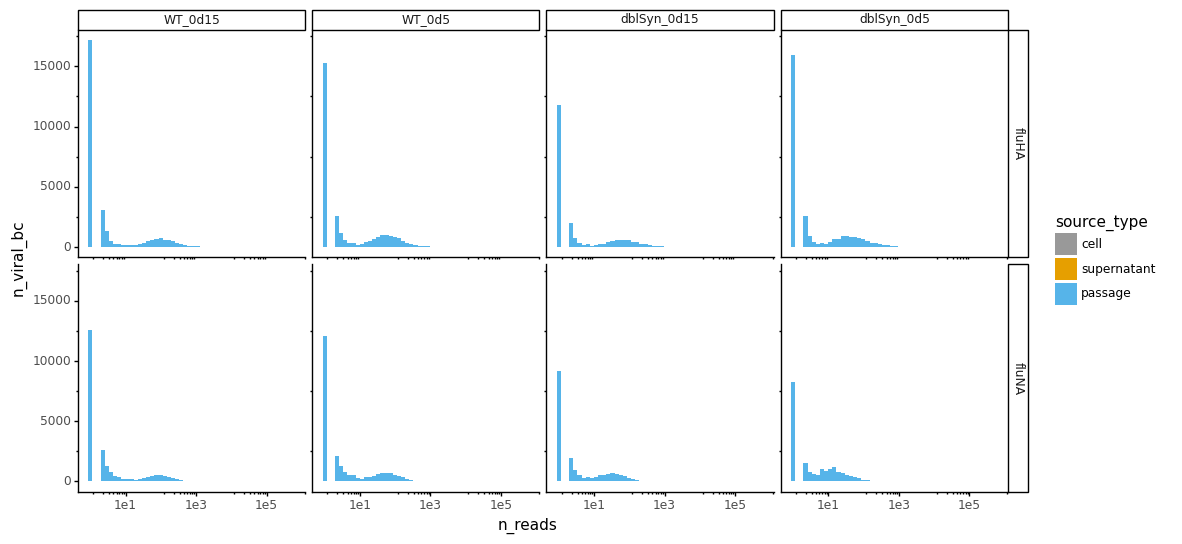

In [18]:
p = (ggplot(barcode_counts_df.query('source_type=="passage"'), aes(x='n_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [24]:
barcode_counts_wide = pd.pivot_table(barcode_counts_df, index=['segment','viral_bc'], columns=['sample','source_type'], values=['n_reads'])
barcode_counts_wide = barcode_counts_wide.rename(columns=str).reset_index()
barcode_counts_wide.columns = ['_'.join(tup) for tup in barcode_counts_wide.columns.values]
barcode_counts_wide = barcode_counts_wide.rename(columns={'segment__': 'segment',
                                                          'viral_bc__': 'viral_bc'})
barcode_counts_wide = barcode_counts_wide.apply(lambda x: numpy.log10(x) if numpy.issubdtype(x.dtype, numpy.number) else x)
barcode_counts_wide = barcode_counts_wide.fillna(0)

In [25]:
barcode_counts_wide.describe()

,n_reads_Unid_1_supernatant,n_reads_Unid_2_supernatant,n_reads_Unid_3_cell,n_reads_WT_0d15_cell,n_reads_WT_0d15_supernatant,n_reads_WT_0d15_passage,n_reads_WT_0d5_cell,n_reads_WT_0d5_supernatant,n_reads_WT_0d5_passage,n_reads_dblSyn_0d15_cell,n_reads_dblSyn_0d15_supernatant,n_reads_dblSyn_0d15_passage,n_reads_dblSyn_0d5_cell,n_reads_dblSyn_0d5_supernatant,n_reads_dblSyn_0d5_passage
count,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000,530900.000000
mean,0.036573,0.034642,0.058022,0.058579,0.060517,0.049019,0.114309,0.061062,0.058923,0.140936,0.084622,0.041956,0.136435,0.000205,0.053681
std,0.259115,0.250942,0.257180,0.288516,0.326702,0.289389,0.385603,0.332120,0.306855,0.420430,0.379697,0.256933,0.397032,0.016342,0.279957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.132404,4.216509,5.461479,4.199892,4.958822,4.515781,5.488569,5.306303,4.586666,4.396007,5.429397,5.743579,4.272004,1.770852,5.652688


In [26]:
sns.set(style="ticks")
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

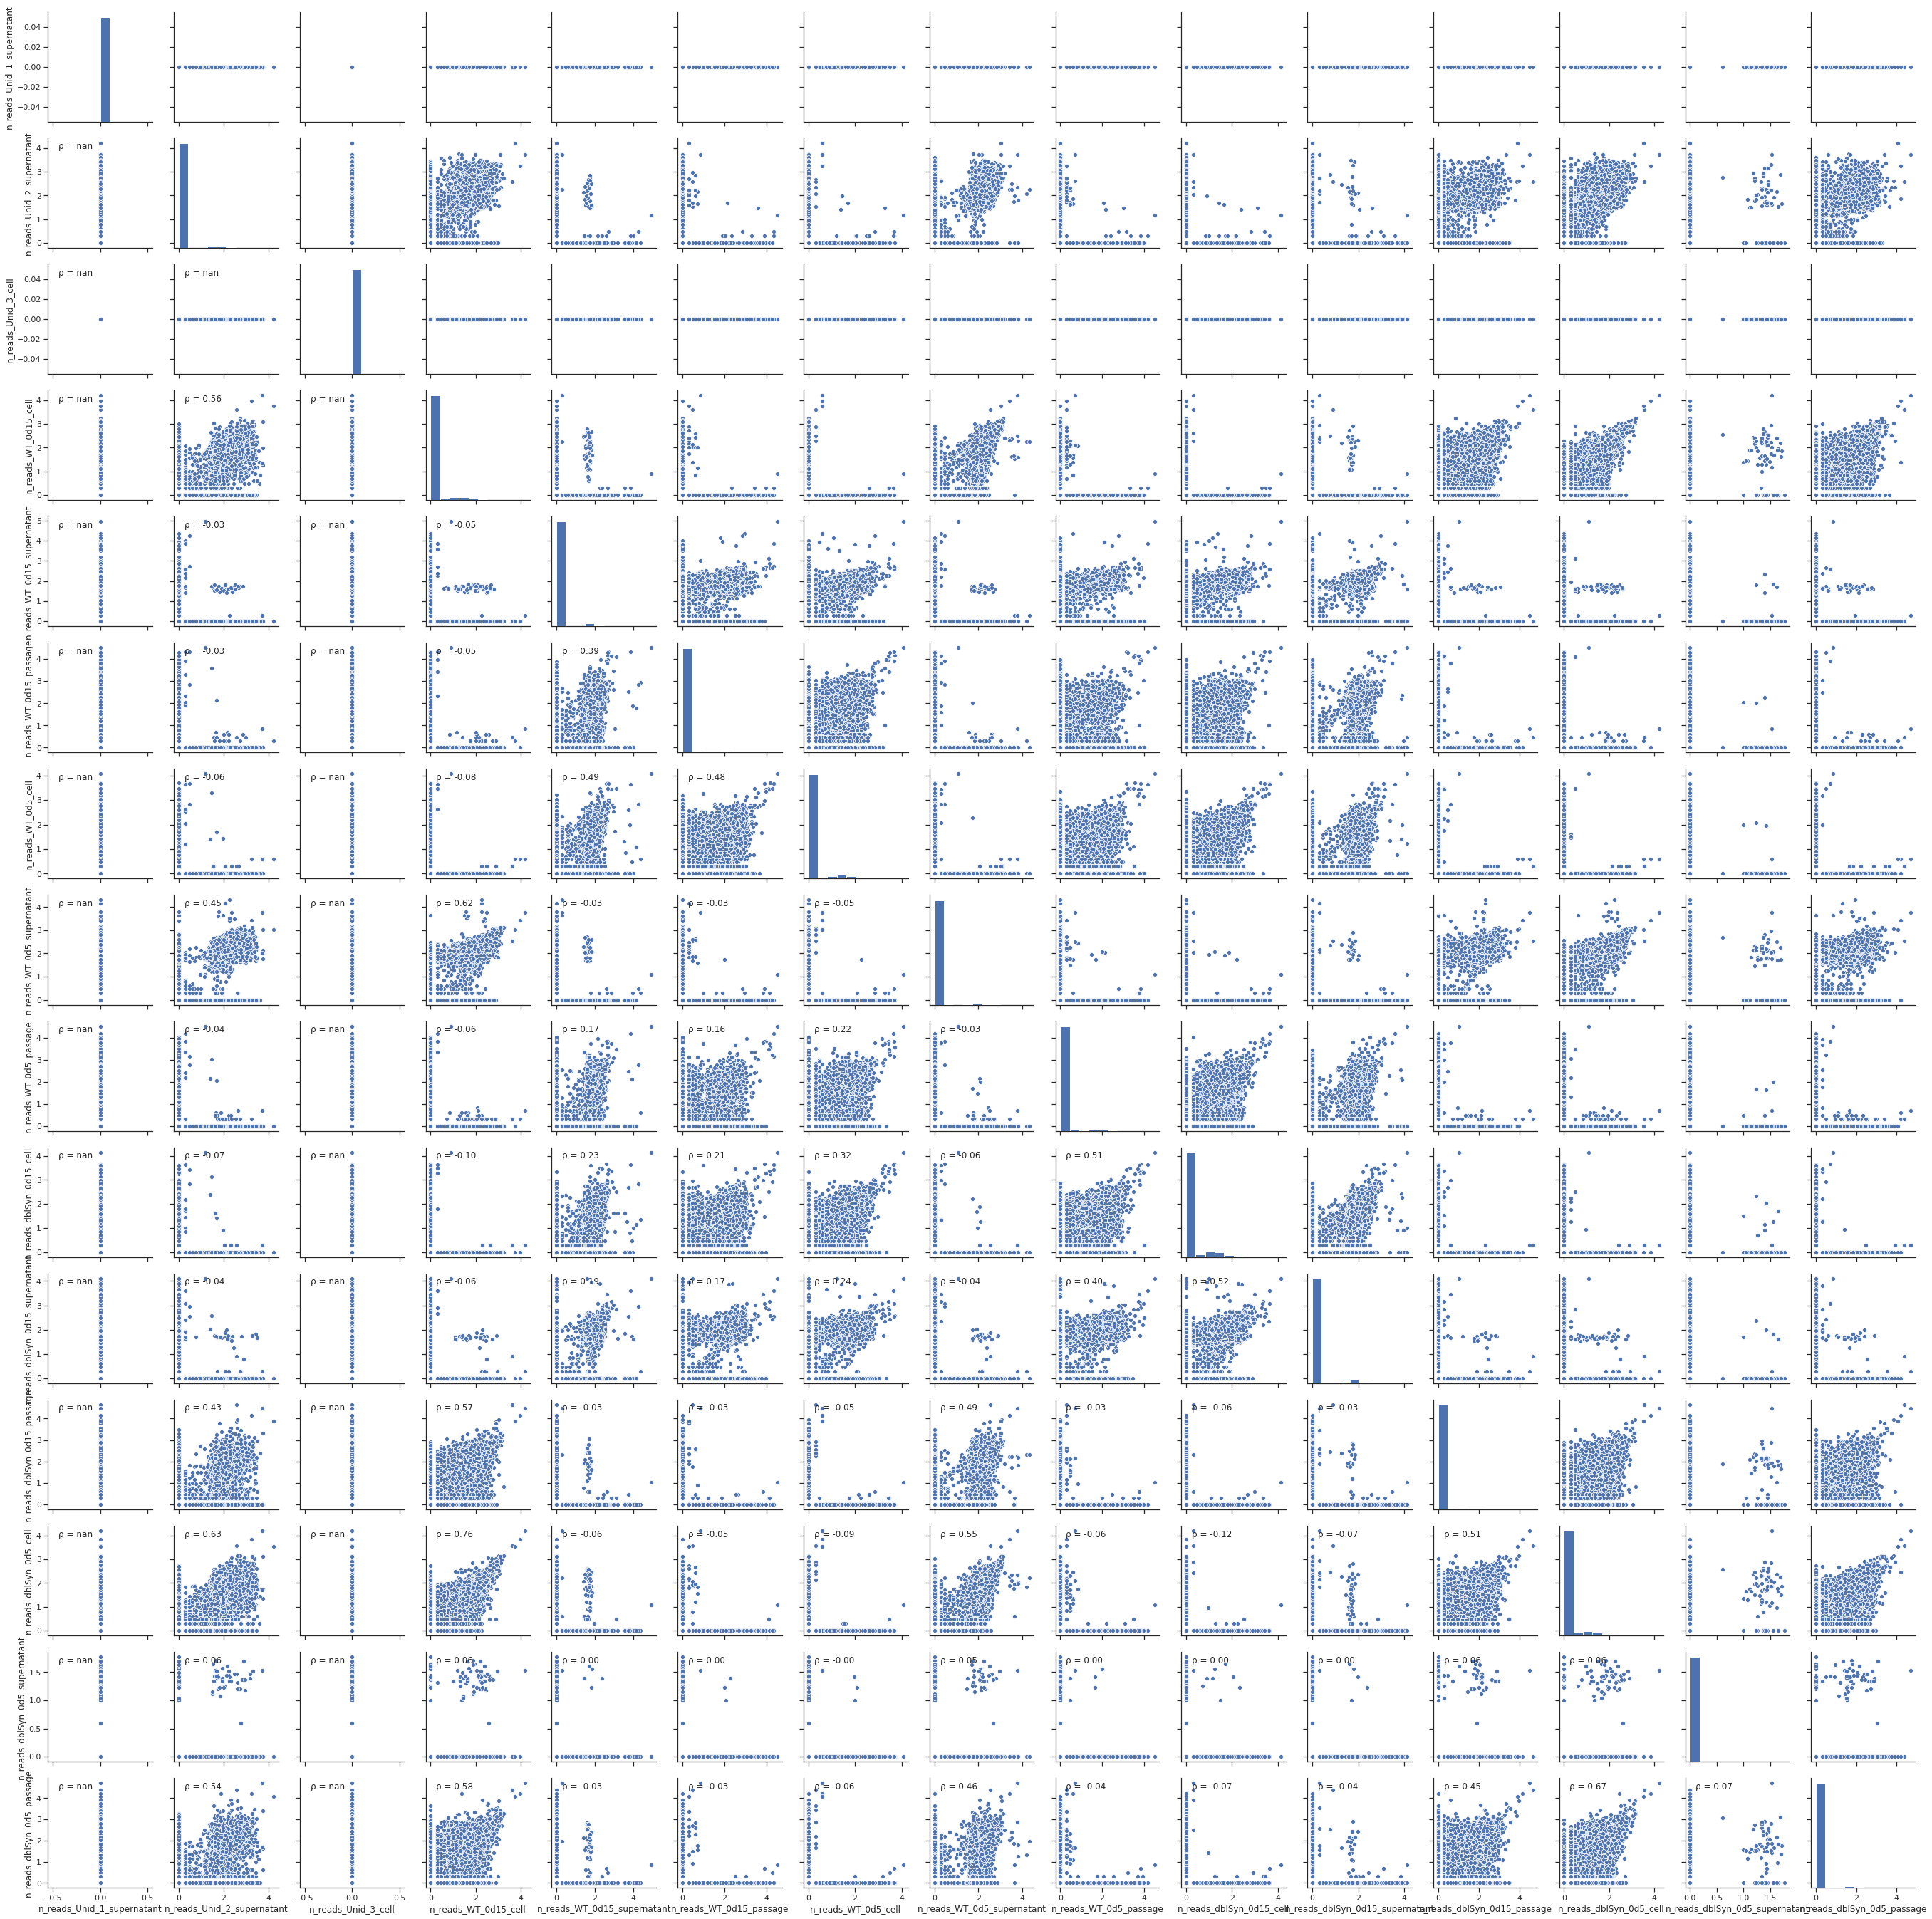

In [27]:
p = sns.pairplot(barcode_counts_wide.query('segment == "fluHA"'))
p.map_lower(corrfunc)
plt.show()

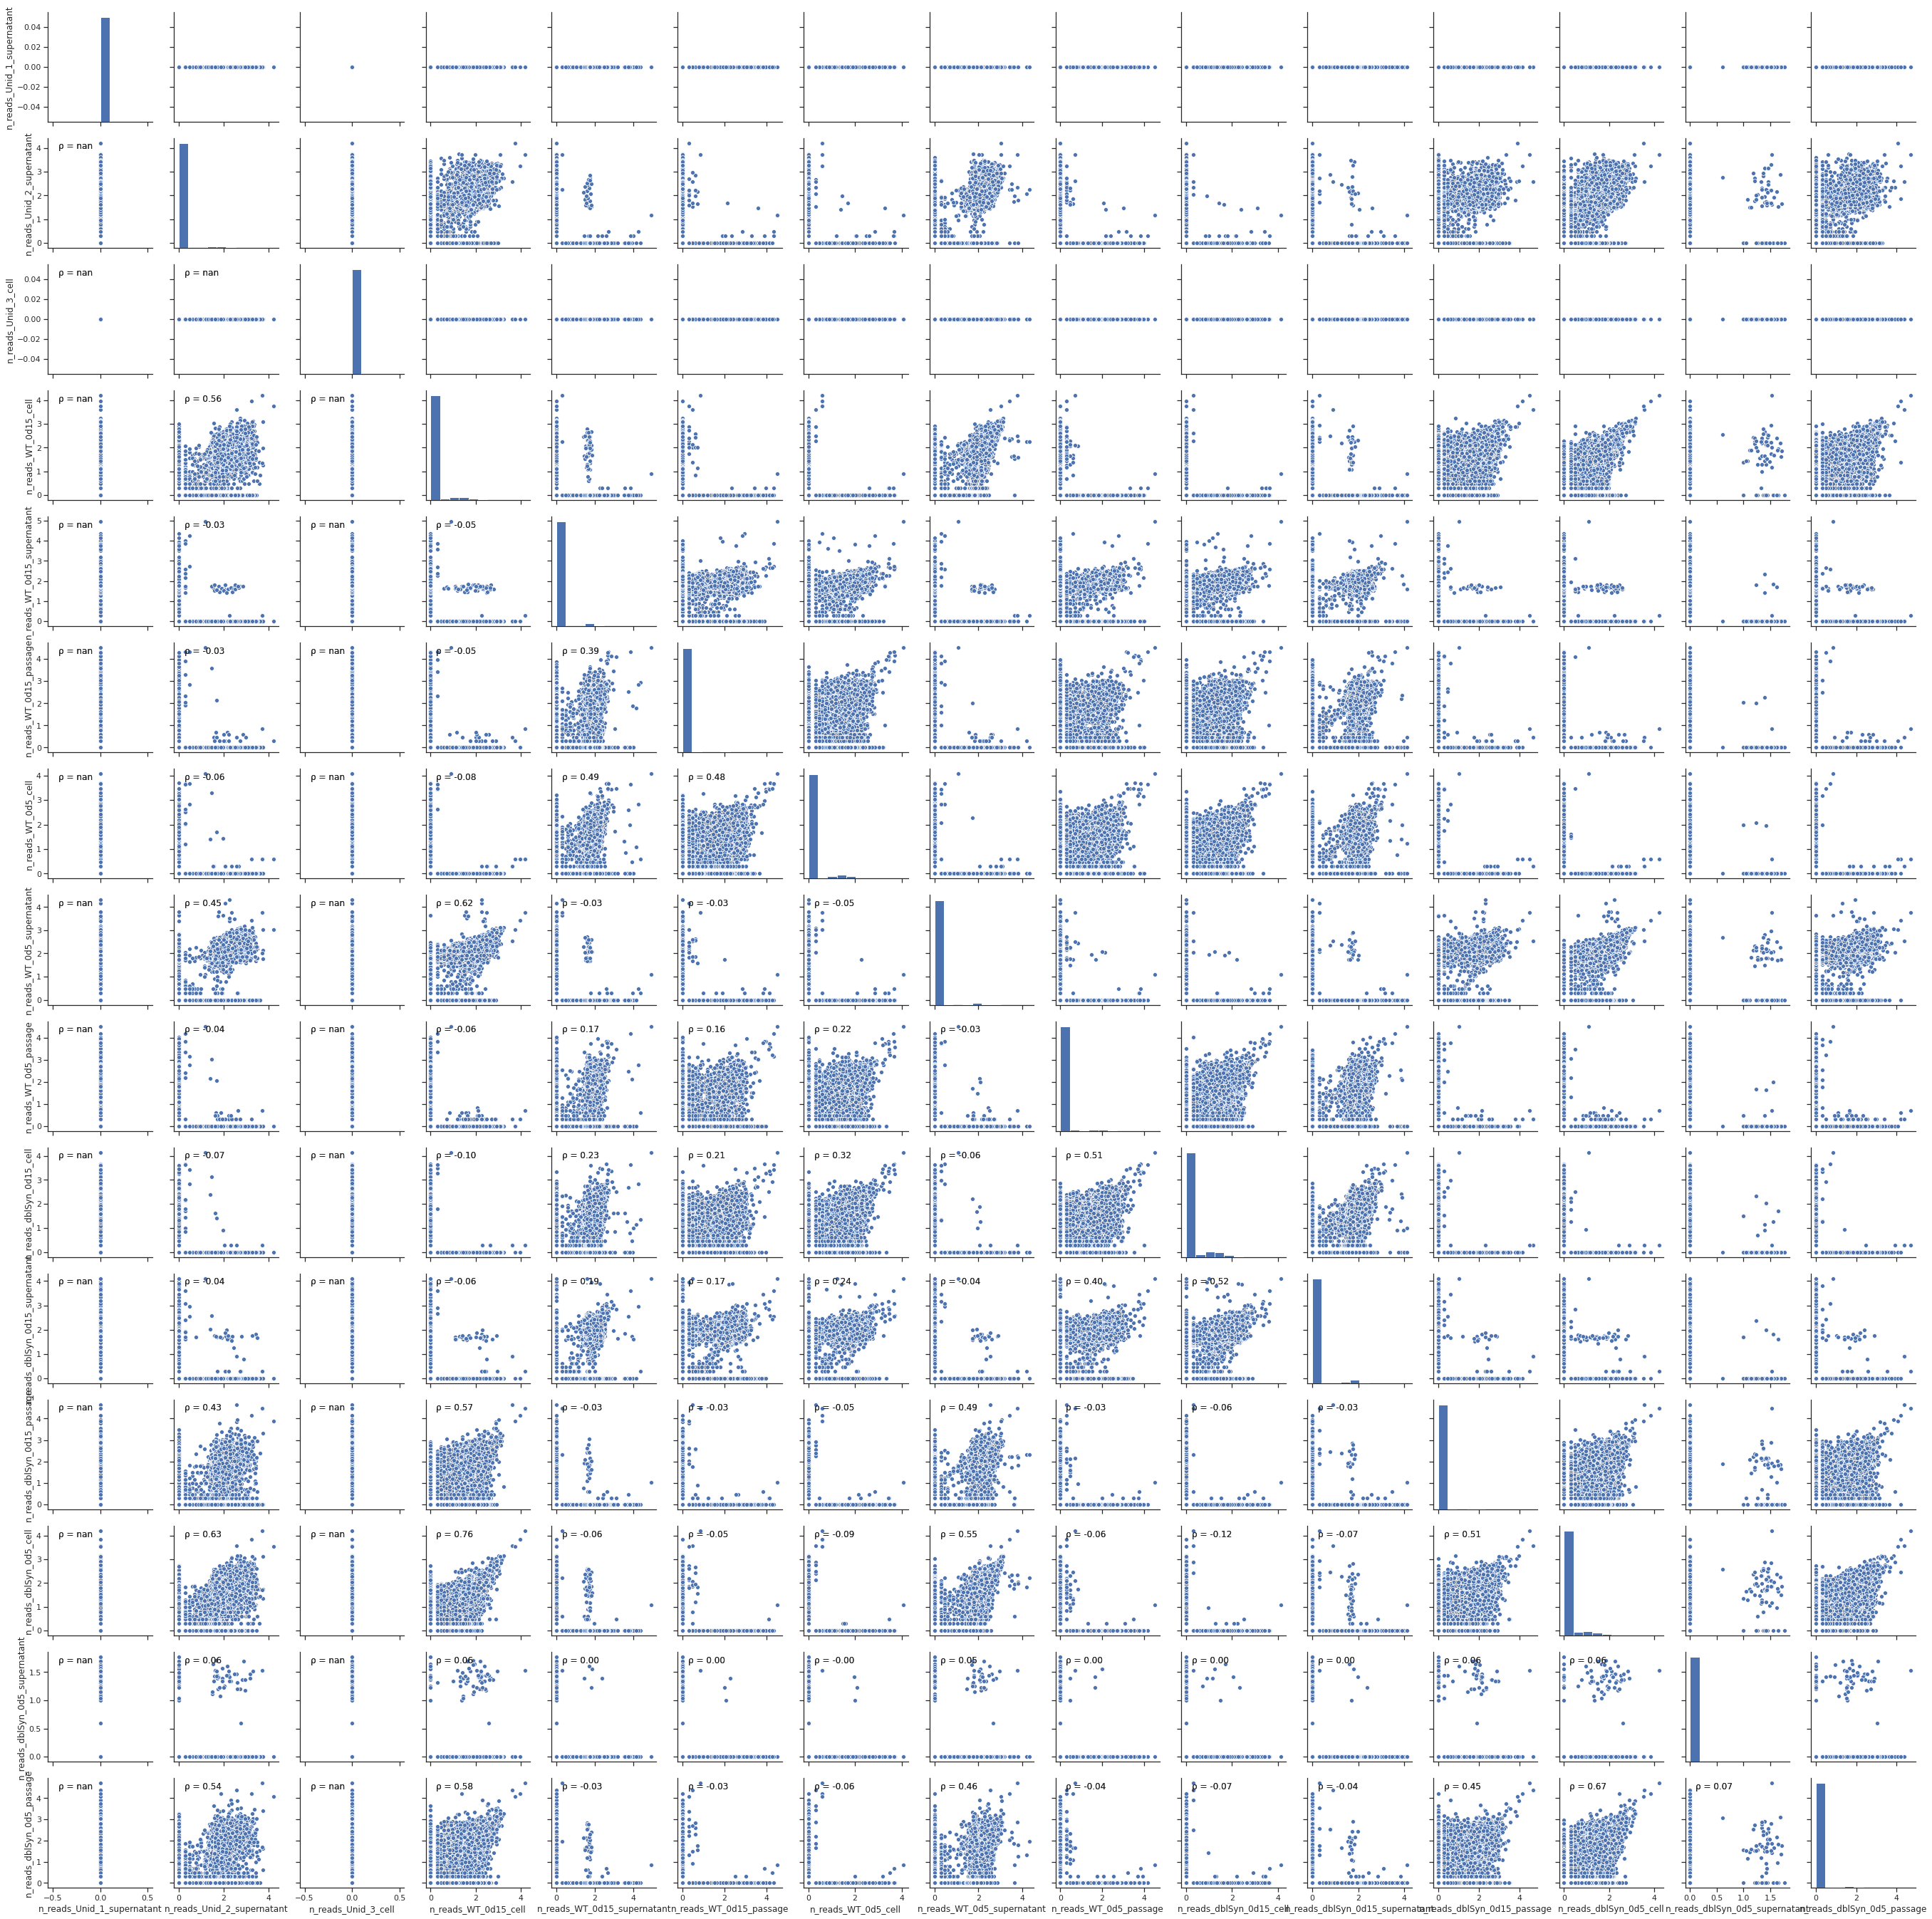

In [28]:
sns.pairplot(barcode_counts_wide.query('segment == "fluNA"'))
p.map_lower(corrfunc)
plt.show()